# Create SimPEG model from image file
Trying to recreate this GIFTools utility
<https://giftoolscookbook.readthedocs.io/en/latest/content/recipes/other/imageInInversion.html>

In [1]:
from skimage import io, color
from scipy.ndimage import zoom
from sklearn.cluster import KMeans
import numpy as np
from discretize import TensorMesh
import matplotlib.pyplot as plt

In [2]:
def make_clusters(image, num_clusters,plot=None):
    """
    segment a 2D image into clusters using scikit-learn Kmeans clustering.
    This is a helper function for the make_model function.

    Parameters
    ----------
    image : str
        Path to the image file.
    num_clusters : int
        Number of clusters to segment the image into.
    plot : bool, optional
        If True, plot the clustered image.

    Returns
    -------
    clustered_image : ndarray
        The clustered image of the same shape as the input image.
    labels : ndarray
        The labels of the clusters.
    """
    # Image Processing and Segmentation
    geological_map = io.imread(image)
    if geological_map.shape[-1] == 4:
        geological_map = color.rgba2rgb(geological_map)  # Convert RGBA to RGB if needed
    pixels = geological_map.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_clusters, n_init="auto")
    kmeans.fit(pixels)
    labels = kmeans.labels_

    clustered_image = labels.reshape(geological_map.shape[:2])

    if plot is not None:
        plt.colorbar(plt.imshow(clustered_image,cmap='jet'))

    return clustered_image, labels

def make_model(clustered_image, background_value, cluster_values,cluster_depths=None, mesh=None,dim=None, **kwargs):
    """
    Create a SimPEG model given a clustered image. A default mesh of 50x50x30 cells is created if not provided.
    If a 2D mesh is provided, the clustered image is treated as a cross-section. If a 3D mesh is provided, the clustered imagine is treaded as a plan-map.

    TODO: Add topo; Account for padding (add core and domain mesh)

    Parameters
    ----------
    clustered_image : ndarray
        The clustered image.
    background_value : float
        The background value for the property model.
    cluster_values : dict
        Dictionary mapping cluster labels to their values.
    cluster_depths : dict
        Dictionary mapping cluster labels to their depths in case of 3D model.
    mesh : TensorMesh, optional
        The mesh to use. If not provided, a deafult mesh will be created.
        Default mesh is a 3D mesh with 50x50x30 cells.
    dim : int, optional
        The dimension of the model. If not provided, the model is treated as 2D.
        If provided, the model is treated as 3D.
    Returns
    -------
    mesh : TensorMesh
        The mesh used.
    model : ndarray
        The created model.
    """
    # Mesh Generation
    if mesh is None:
        domainx = clustered_image.shape[1]
        domainy = clustered_image.shape[0]
        domainz = 500

        nx = 50
        ny = 50
        nz = 30

        dx = domainx/nx
        dy = domainy/ny
        dz = domainz/nz

        hx = [(dx,nx)]
        hy = [(dy,ny)]
        hz = [(dz,nz)]

        if dim == 2 or cluster_depths is None:
            mesh = TensorMesh([hx, hy], x0="0N")
        else:
            mesh = TensorMesh([hx, hy, hz], x0="00N")

    # Downsampled image
    desired_size = (mesh.shape_cells[0], mesh.shape_cells[1])
    downsampled_image = zoom(clustered_image,
                             (desired_size[0] / clustered_image.shape[0],
                              desired_size[1] /clustered_image.shape[1]),
                             order=0)

    # Create a property model based on zone depths
    property_model = background_value*np.ones(mesh.nC)
    reshaped_model = mesh.reshape(property_model, 'CC', 'CC', 'M')
    for i in range(downsampled_image.shape[0]):
        for j in range(downsampled_image.shape[1]):
            cluster_label = downsampled_image[j,i]
            if cluster_label in cluster_values:
               zone_value = cluster_values[cluster_label]
               if dim == 3:
                  zone_depth = cluster_depths[cluster_label]
                  reshaped_model[i,j,:zone_depth] = zone_value
               else:
                  reshaped_model[i,j] = zone_value

    model = mesh.reshape(np.flip(reshaped_model,axis=1), 'CC', 'CC', 'V')

    return mesh, model

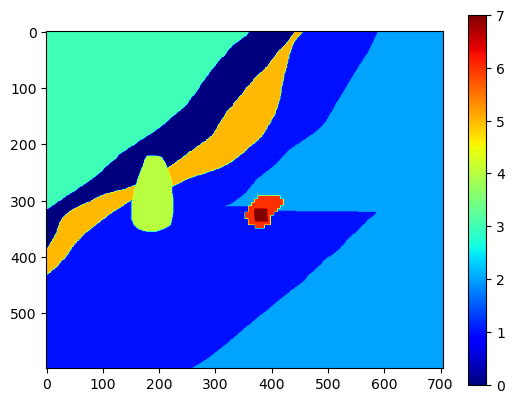

In [3]:
# Load the image and process it
input_image = 'examples/geology2.tif'
segmented_image, labels = make_clusters(input_image, num_clusters=8, plot=True)

In [4]:
# Keys for the physical property values of the clusters
cluster_key = {
    0: 1e-3,
    1: 1e-1,
    2: 1e-2,
    3: 5e0,
    4: 5e-2,
    5: 5e-1,
    6: 1e3,
    7: 1e4
}
# Keys for the depth (in terms of number of z cells) of each cluster
cluster_depth = {
    0: 30,
    1: 30,
    2: 30,
    3: 30,
    4: 30,
    5: 30,
    6: 30,
    7: 30
}
mesh, model = make_model(clustered_image=segmented_image,background_value=1e-3,cluster_values=cluster_key,cluster_depths=cluster_depth)

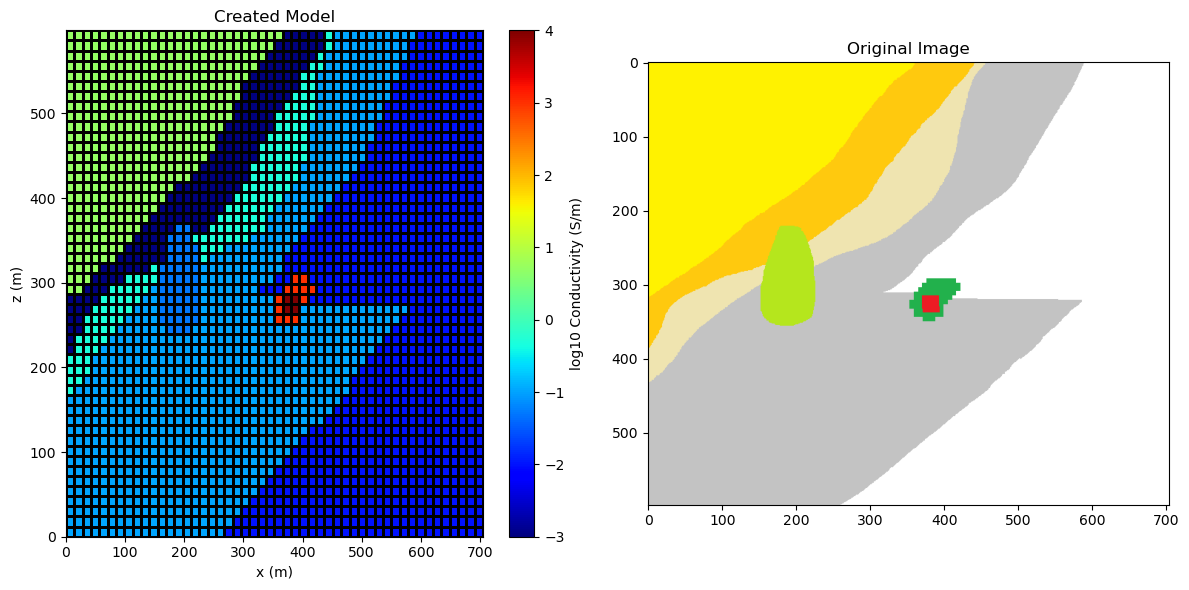

In [5]:
# Plot the property model
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

out = mesh.plot_slice(np.log10(model), normal='z', ax=ax1, ind=0, grid=True, pcolor_opts={"cmap":"jet"})
cb = plt.colorbar(out[0], orientation="vertical")
cb.set_label("log10 Conductivity (S/m)")
ax1.set_title('Created Model')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('z (m)')
plt.gca().set_aspect('equal', adjustable='box')

#plt.colorbar(ax2.imshow(input_image))
ax2.imshow(io.imread(input_image))
ax2.set_title('Original Image')
plt.tight_layout()